In [1]:
import pandas as pd
from idaes.core.solvers import get_solver
from pyomo.environ import ConcreteModel, RangeSet, Var, log10, minimize


In [2]:
df = pd.read_excel("data for parmest.xlsx", sheet_name = "Sheet3")
index = df.shape[0]
idx_list = RangeSet(0,index-1)
print(df)

       dosage  Acid conc (M)    logD Y   logD Ce   logD Nd   logD Sm  \
0    4.987853       0.574116 -1.640000 -1.920000 -1.810000 -1.670000   
1    4.978542       0.297167 -1.150000 -1.480000 -1.540000 -1.620000   
2    4.929476       0.159956 -0.460000 -1.510000 -1.460000 -1.550000   
3    4.813219       0.072946  0.350000 -1.340000 -1.440000 -1.550000   
4    4.751685       0.047753  0.870000 -1.300000 -1.320000 -1.110000   
5    4.723110       0.034198  1.200000 -1.170000 -1.190000 -0.850000   
6    4.709438       0.029923  1.350000 -1.020000 -1.000000 -0.720000   
7    1.991579       0.581278 -1.614155 -1.852616 -1.741725 -1.852616   
8    1.980691       0.295960 -1.170221 -1.458465 -1.514597 -1.578512   
9    1.933668       0.157493 -0.456245 -1.485682 -1.458465 -1.545445   
10   1.827041       0.068058  0.340148 -1.363124 -1.432752 -1.578512   
11   1.770545       0.038332  0.842269 -1.302435 -1.321819 -1.090050   
12   1.744097       0.024339  1.191603 -1.155939 -1.184925 -0.83

In [3]:
Element_list = ['Y','Ce','Nd','Sm','Gd','Dy','La','Pr']

In [5]:
m = ConcreteModel()

m.Acid = Var(idx_list)
m.dosage = Var(idx_list)
m.logD_exp = Var(idx_list, Element_list)
m.logD_model = Var(idx_list, Element_list)

for i in idx_list:
    m.Acid[i].fix(df['Acid conc (M)'][i])
    m.dosage[i].fix(df['dosage'][i])
    for e in Element_list:
        m.logD_exp[i,e].fix(df[f'logD {e}'][i])

variable_list = [1,2]

# m.a = Var(variable_list, Element_list, initialize = 0.1)
# m.b = Var(variable_list, Element_list, initialize = 0.1)
m.a = Var(variable_list, Element_list, initialize=0.1, bounds=lambda m, i, e: (0, None) if i == 2 else (None, None))
m.b = Var(variable_list, Element_list, initialize=0.1, bounds=lambda m, i, e: (0, None) if i == 2 else (None, None))

# for e in Element_list:
#     m.b[2,e].set_lb(0)

@m.Constraint(idx_list, Element_list)
def logD_model_rule(m,i,e):
    return m.logD_model[i,e] == (m.a[1,e]+m.a[2,e]*m.dosage[i])*log10(m.Acid[i]) + (m.b[1,e]+m.b[2,e]*log10(m.dosage[i]))

@m.Expression()
def SSE(m):
    return sum(((m.logD_exp[i,e] - m.logD_model[i,e])**2)*df[f'w_{e}'][i] for i in idx_list for e in Element_list)

@m.Objective(sense=minimize)
def objective_rule(m):
    return m.SSE

solver=get_solver('ipopt_v2')
solver.solve(m, tee=True)


Ipopt 3.13.2: linear_solver="ma57"
max_iter=200
nlp_scaling_method="gradient-based"
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collect

{'Problem': [{'Lower bound': None, 'Upper bound': 2.370371332268708, 'Number of objectives': 1, 'Number of constraints': nan, 'Number of variables': nan, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Termination message': 'TerminationCondition.convergenceCriteriaSatisfied'}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In [6]:
m.a.pprint()
m.b.pprint()

a : Size=16, Index={1, 2}*{Y, Ce, Nd, Sm, Gd, Dy, La, Pr}
    Key       : Lower : Value                  : Upper : Fixed : Stale : Domain
    (1, 'Ce') :  None :    -0.6197203014635994 :  None : False : False :  Reals
    (1, 'Dy') :  None :    -1.8528394079358208 :  None : False : False :  Reals
    (1, 'Gd') :  None :    -1.1686892136101357 :  None : False : False :  Reals
    (1, 'La') :  None :    -0.6426167625059651 :  None : False : False :  Reals
    (1, 'Nd') :  None :    -0.6363987680510207 :  None : False : False :  Reals
    (1, 'Pr') :  None :    -0.6269473512731447 :  None : False : False :  Reals
    (1, 'Sm') :  None :    -0.8210255116048191 :  None : False : False :  Reals
     (1, 'Y') :  None :     -2.132563785577246 :  None : False : False :  Reals
    (2, 'Ce') :     0 :                    0.0 :  None : False : False :  Reals
    (2, 'Dy') :     0 :  4.962374987038182e-08 :  None : False : False :  Reals
    (2, 'Gd') :     0 :    0.00782033460266663 :  None : False

In [35]:
no_data = 0
for e in Element_list:
    no_data +=(df[f'w_{e}'] == 1).sum()
no_data

np.int64(100)

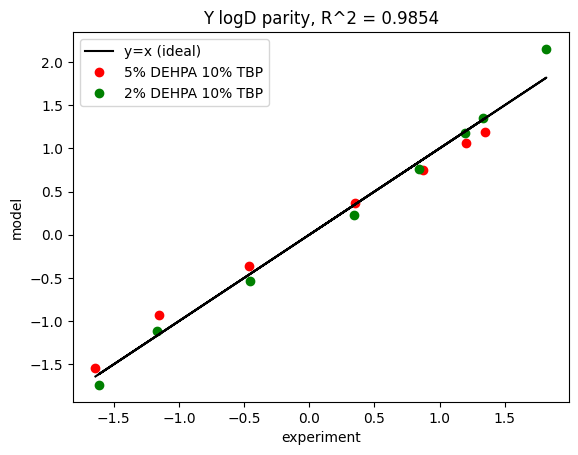

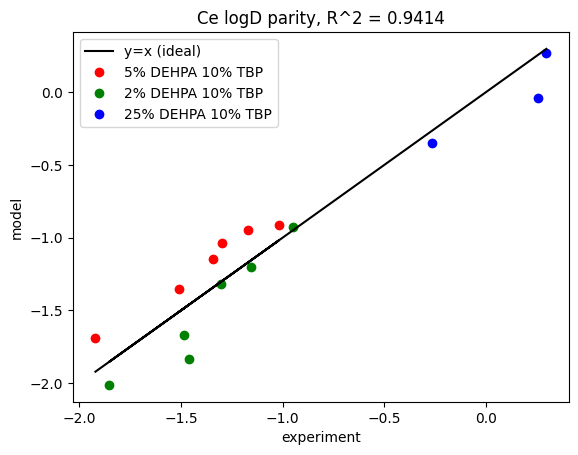

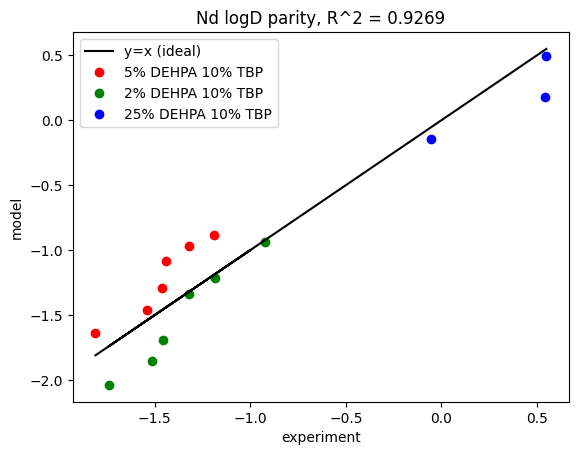

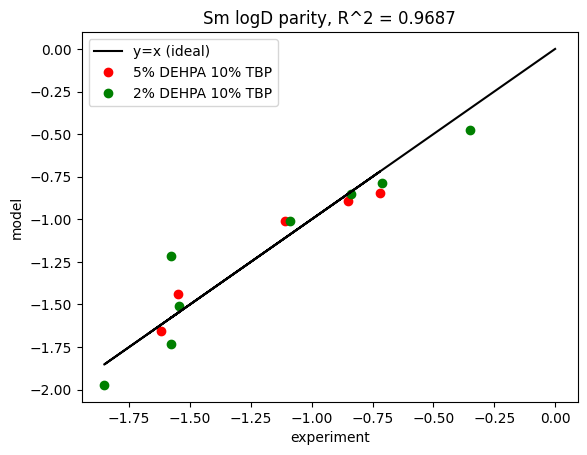

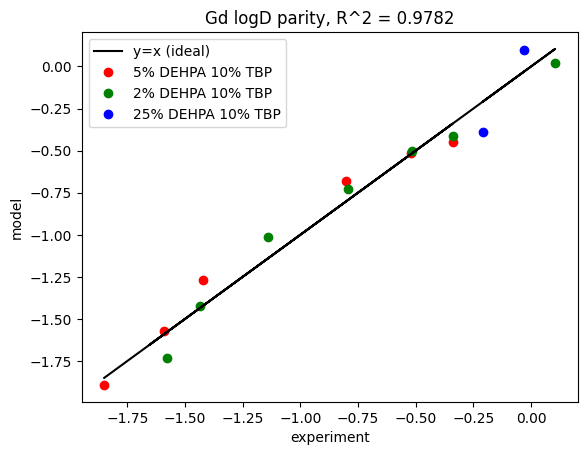

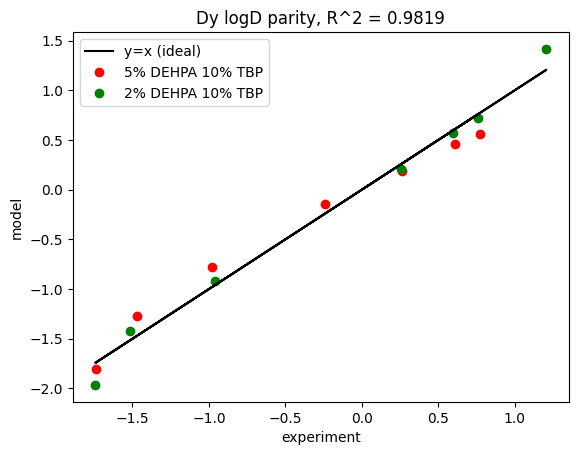

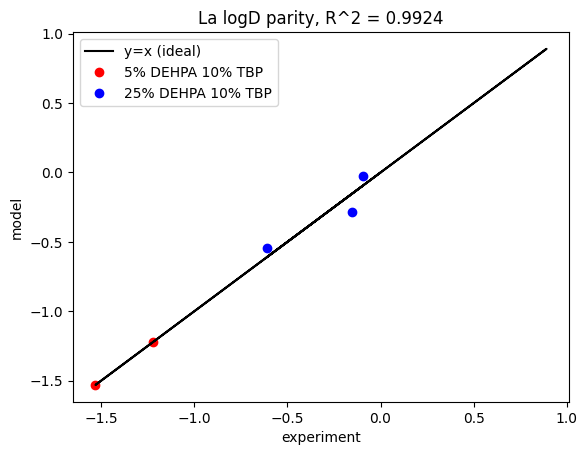

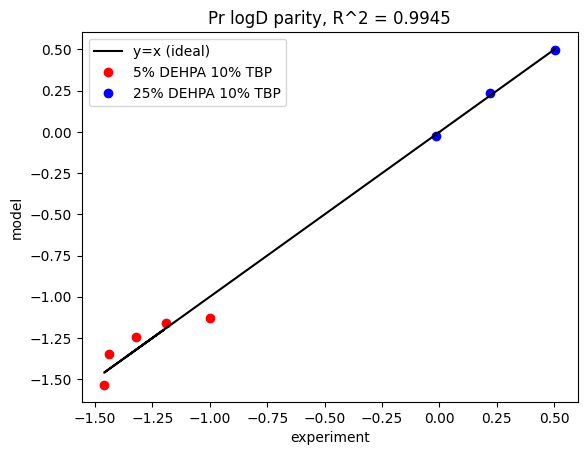

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

for e in Element_list:
    x = [m.logD_exp[i, e].value*df[f'w_{e}'][i] for i in idx_list]
    y = [m.logD_model[i, e].value*df[f'w_{e}'][i] for i in idx_list]
    x_ideal = [m.logD_exp[i, e].value for i in idx_list]
    plt.plot(x_ideal, x_ideal, label='y=x (ideal)', linestyle='-', color='black')
    red_points = []
    green_points = []
    blue_points=[]
    for i in idx_list:
        if df[f'w_{e}'][i] == 1:
            if 2 <df['dosage'][i] <5:
                red_points.append(plt.scatter(x[i], y[i], color='red', label='5% DEHPA 10% TBP'))
            if df['dosage'][i] < 2:
                green_points.append(plt.scatter(x[i], y[i], color='green', label='2% DEHPA 10% TBP'))
            if 5 <df['dosage'][i] <= 25:
                blue_points.append(plt.scatter(x[i], y[i], color='blue', label='25% DEHPA 10% TBP'))
    plt.xlabel('experiment')
    plt.ylabel('model')
    plt.title(f"{e} logD parity, R^2 = {r2_score(x, y):.4f}")
    
    # Build legend handles/labels manually to avoid duplicates
    handles = [plt.Line2D([], [], color='black', label='y=x (ideal)')]
    if red_points:
        handles.append(plt.Line2D([], [], color='red', marker='o', linestyle='None', label='5% DEHPA 10% TBP'))
    if green_points:
        handles.append(plt.Line2D([], [], color='green', marker='o', linestyle='None', label='2% DEHPA 10% TBP'))
    if blue_points:
        handles.append(plt.Line2D([], [], color='blue', marker='o', linestyle='None', label='25% DEHPA 10% TBP'))
    labels = [h.get_label() for h in handles]
    plt.legend(handles, labels)
    plt.show()

In [9]:
df_parameters = pd.DataFrame(index=Element_list, columns=['a1','a2','b1','b2'])
for e in Element_list:
    df_parameters.loc[e, 'a1'] = m.a[1,e].value
    df_parameters.loc[e, 'a2'] = m.a[2,e].value
    df_parameters.loc[e, 'b1'] = m.b[1,e].value
    df_parameters.loc[e, 'b2'] = m.b[2,e].value

In [10]:
df_parameters

,a1,a2,b1,b2
Y,-5.519137,0.000002,1.073645,0.0
Ce,-1.542955,0.0,-1.547707,1.033566
Nd,-1.520486,0.0,-1.642276,1.241904
Sm,-2.136716,0.0,-0.894641,0.0
Gd,-5.683842,0.546762,-0.465533,0.04988
Dy,-4.697244,0.000001,0.486699,0.0
La,-3.946822,0.0,-1.67672,1.038171
Pr,-3.412202,0.0,-2.308535,1.855887


In [42]:
with pd.ExcelWriter('data for parmest.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_parameters.to_excel(writer, sheet_name='new parameter values')

In [21]:
for i in RangeSet(0,3):
    for j in RangeSet(0,1):
        print(j+1+2*i)

1
2
3
4
5
6
7
8


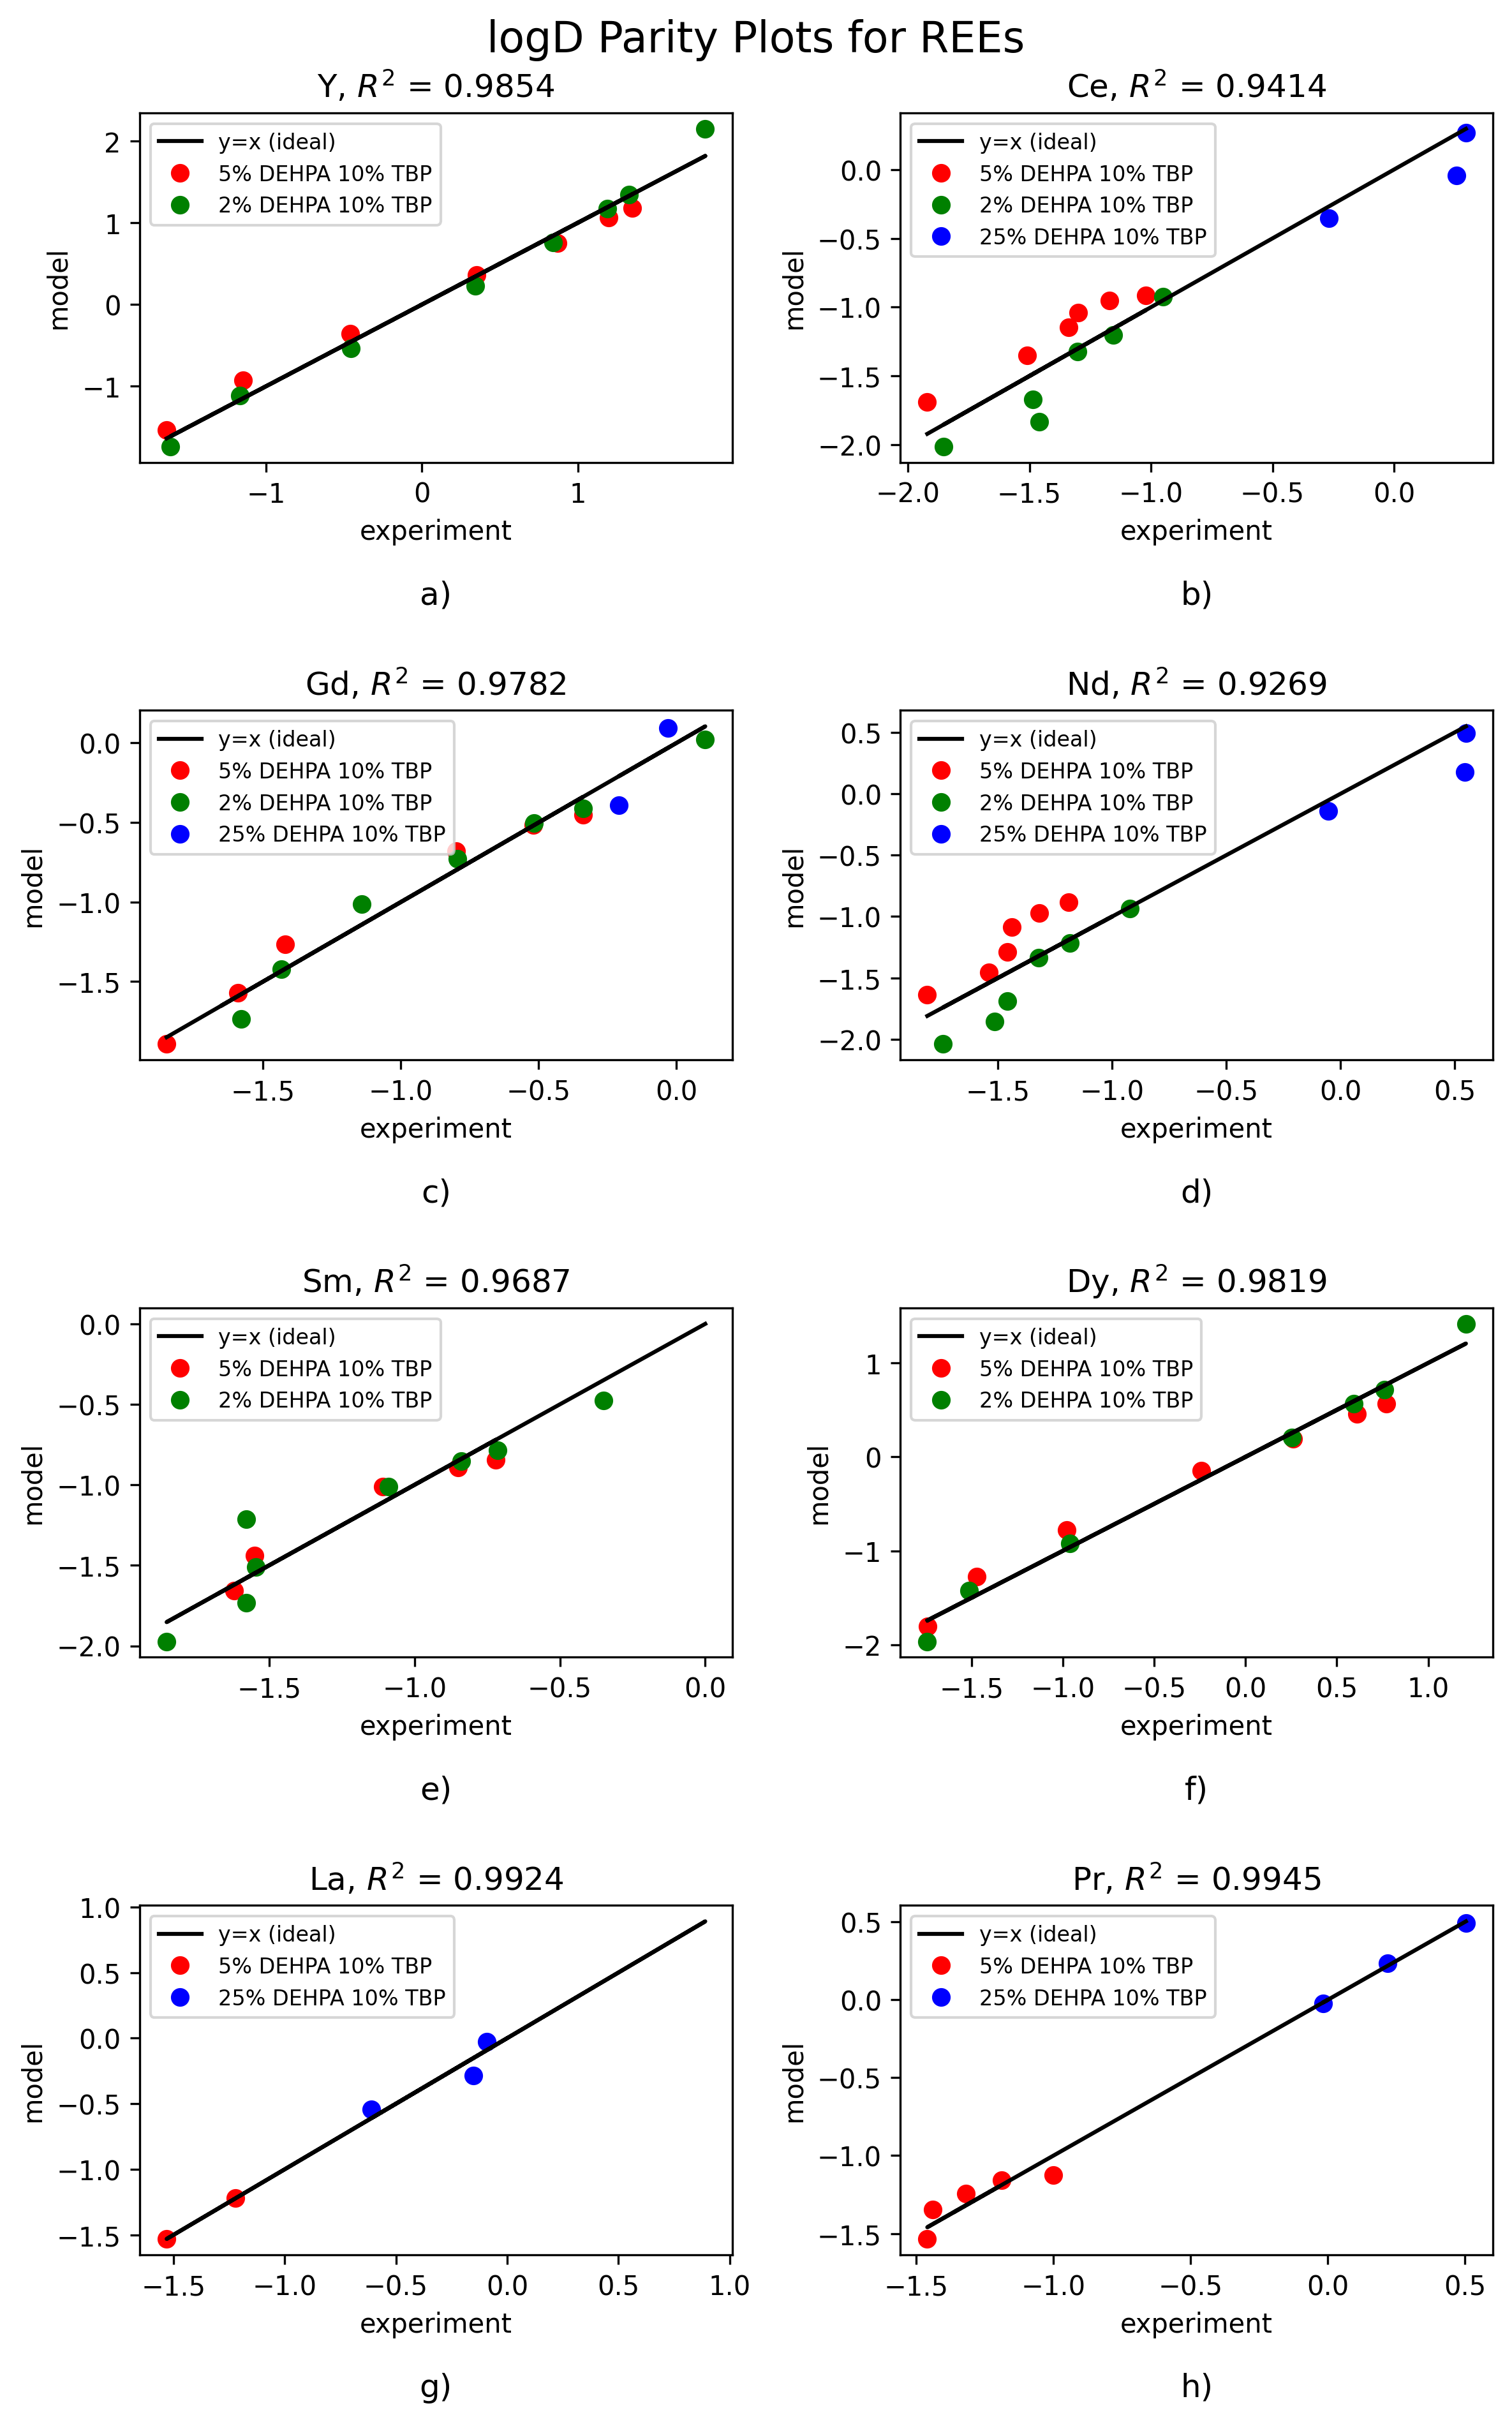

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

fig, ax = plt.subplots(4,2,figsize=(8,13),dpi=300)
fig.suptitle("logD Parity Plots for REEs", fontsize=16)
element_dict = dict(zip(RangeSet(1,8),['Y','Ce','Gd','Nd','Sm','Dy','La','Pr']))
text_label = dict(zip(RangeSet(1,8),['a)','b)','c)','d)','e)','f)','g)','h)']))
for a in RangeSet(0,3):
    for b in RangeSet(0,1):
        e = element_dict[b+1+2*a]
        txt_label=text_label[b+1+2*a]
        x = [m.logD_exp[i, e].value*df[f'w_{e}'][i] for i in idx_list]
        y = [m.logD_model[i, e].value*df[f'w_{e}'][i] for i in idx_list]
        x_ideal = [m.logD_exp[i, e].value for i in idx_list]
        ax[a,b].plot(x_ideal, x_ideal, label='y=x (ideal)', linestyle='-', color='black')
        red_points = []
        green_points = []
        blue_points=[]
        for i in idx_list:
            if df[f'w_{e}'][i] == 1:
                if 2 <df['dosage'][i] <5:
                    red_points.append(ax[a,b].scatter(x[i], y[i], color='red', label='5% DEHPA 10% TBP'))
                if df['dosage'][i] < 2:
                    green_points.append(ax[a,b].scatter(x[i], y[i], color='green', label='2% DEHPA 10% TBP'))
                if 5 <df['dosage'][i] <= 25:
                    blue_points.append(ax[a,b].scatter(x[i], y[i], color='blue', label='25% DEHPA 10% TBP'))
        ax[a,b].set(xlabel='experiment',ylabel='model')
        ax[a,b].set_title(f"{e}, $R^2$ = {r2_score(x, y):.4f}")
        ax[a,b].text(0.5, -0.38, txt_label, transform=ax[a,b].transAxes,
                     ha='center', va='center', fontsize=12)
        # Build legend handles/labels manually to avoid duplicates
        handles = [plt.Line2D([], [], color='black', label='y=x (ideal)')]
        if red_points:
            handles.append(plt.Line2D([], [], color='red', marker='o', linestyle='None', label='5% DEHPA 10% TBP'))
        if green_points:
            handles.append(plt.Line2D([], [], color='green', marker='o', linestyle='None', label='2% DEHPA 10% TBP'))
        if blue_points:
            handles.append(plt.Line2D([], [], color='blue', marker='o', linestyle='None', label='25% DEHPA 10% TBP'))
        labels = [h.get_label() for h in handles]
        ax[a,b].legend(handles, labels, fontsize=8)
plt.tight_layout()
        